# **1. Análisis del problema y objetivo de negocio**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import io
import matplotlib.pyplot as plt
import datetime

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ContactoCobranza.csv to ContactoCobranza.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['ContactoCobranza.csv']),encoding="latin-1",sep=";")
df.head()

,MES,CLIENTE,NRO_VEC_COB,PDPs_ROTAS,ESTADO_PDP,NRO_CUOTAS,MES_0,MES_1,MES_2,FECHALLAMADA,HORA,DEUDA_TOTAL,ESTATUS,ACTIVACION,MORA,TIPOCONTACTO
0,201402,C00001,NaN,0,0,"<24, 48]",244.86,0.00,245.26,03/02/2014,15.0,3816.34,BT,2012.0,1.0,COEF
1,201402,C00002,<=10,0,0,>48,610.58,612.69,611.54,18/02/2014,9.0,13620.50,BT,2012.0,1.0,COEF
2,201402,C00003,<=10,>0,0,"<24, 48]",2138.73,0.00,NaN,05/02/2014,16.0,18968.50,BT,2013.0,0.0,CNE
3,201402,C00004,>10,0,0,"<24, 48]",323.07,46.85,74.26,24/02/2014,19.0,2459.84,BT,2012.0,0.0,CNE
4,201402,C00005,<=10,0,0,"<24, 48]",920.54,0.00,0.00,12/02/2014,14.0,6591.76,BT,2013.0,0.0,CNE


se requiere aumentar el ratio de contactabilidad, donde la variable objetivo es TIPOCONTACTO:
*   COEF (contacto efectivo)
*   CNE (contacto no efectivo)

para ello identificaremos las **variables independientes que tienen mayor relacion con la variable objetivo** y analizaremos distintos modelos supervisados

# **2. Tipo de Variables**

In [ ]:
#tenemos 16 columnas y 8458 registros
df.shape

(8458, 16)

In [ ]:
df.info()
#observamos que hay 3 columnas con valores nulos
#tenemos variables numericas, categoricas, mes como entero y fecha llamada como object (debe cambiarse)
#la variable target esta como categoria

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8458 entries, 0 to 8457
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MES           8458 non-null   int64  
 1   CLIENTE       8458 non-null   object 
 2   NRO_VEC_COB   6376 non-null   object 
 3   PDPs_ROTAS    8458 non-null   object 
 4   ESTADO_PDP    8458 non-null   int64  
 5   NRO_CUOTAS    7779 non-null   object 
 6   MES_0         8458 non-null   float64
 7   MES_1         8458 non-null   float64
 8   MES_2         7557 non-null   float64
 9   FECHALLAMADA  8458 non-null   object 
 10  HORA          8458 non-null   float64
 11  DEUDA_TOTAL   8458 non-null   float64
 12  ESTATUS       8458 non-null   object 
 13  ACTIVACION    8458 non-null   float64
 14  MORA          8458 non-null   float64
 15  TIPOCONTACTO  8458 non-null   object 
dtypes: float64(7), int64(2), object(7)
memory usage: 1.0+ MB


In [ ]:
#Renombramos los nombres de las columnas para que sean faciles de entender para el negocio
df.rename(index=str,
          columns={"MES":"MES_CAMPAÑA",
                   "CLIENTE":"CODIGO_CLIENTE",
                   "NRO_VEC_COB":"VECES_EN_COBRANZAS",
                   "PDPs_ROTAS":"PROMESAS_ROTAS",
                   "ESTADO_PDP":"ESTADO_PROMESAS",
                   "NRO_CUOTAS":"CUOTAS_ADEUDADAS",
                   "MES_0":"DEUDAVENCIDA_ACTUAL",
                   "MES_1":"DEUDAVENCIDA_1MES",
                   "MES_2":"DEUDAVENCIDA_2MESES",
                   "ACTIVACION":"AÑOACTIVACION"
                   },inplace=True)
df.head()

,MES_CAMPAÑA,CODIGO_CLIENTE,VECES_EN_COBRANZAS,PROMESAS_ROTAS,ESTADO_PROMESAS,CUOTAS_ADEUDADAS,DEUDAVENCIDA_ACTUAL,DEUDAVENCIDA_1MES,DEUDAVENCIDA_2MESES,FECHALLAMADA,HORA,DEUDA_TOTAL,ESTATUS,AÑOACTIVACION,MORA,TIPOCONTACTO
0,201402,C00001,NaN,0,0,"<24, 48]",244.86,0.00,245.26,03/02/2014,15.0,3816.34,BT,2012.0,1.0,COEF
1,201402,C00002,<=10,0,0,>48,610.58,612.69,611.54,18/02/2014,9.0,13620.50,BT,2012.0,1.0,COEF
2,201402,C00003,<=10,>0,0,"<24, 48]",2138.73,0.00,NaN,05/02/2014,16.0,18968.50,BT,2013.0,0.0,CNE
3,201402,C00004,>10,0,0,"<24, 48]",323.07,46.85,74.26,24/02/2014,19.0,2459.84,BT,2012.0,0.0,CNE
4,201402,C00005,<=10,0,0,"<24, 48]",920.54,0.00,0.00,12/02/2014,14.0,6591.76,BT,2013.0,0.0,CNE


In [ ]:
df.describe().round(2)
#se observa a primera vista que DEUDAVENCIDA_ACTUAL, DEUDAVENCIDA_1MES,DEUDAVENCIDA_2MESES y DEUDA_TOTAL tienen outliers
#la hora va de 7 a 20, es un dato numerico pero podemos trabajarlo como periodo del dia
#con año activacion podemos determinar la antiguedad del cliente


,MES_CAMPAÑA,ESTADO_PROMESAS,DEUDAVENCIDA_ACTUAL,DEUDAVENCIDA_1MES,DEUDAVENCIDA_2MESES,HORA,DEUDA_TOTAL,AÑOACTIVACION,MORA
count,8458.00,8458.00,8458.00,8458.00,7557.00,8458.00,8458.00,8458.00,8458.00
mean,201402.99,0.04,610.17,382.41,262.47,12.15,11545.00,2012.28,0.76
std,0.81,0.19,596.45,602.30,598.08,3.74,12518.45,0.88,0.43
min,201402.00,0.00,20.15,0.00,0.00,7.00,546.09,2010.00,0.00
25%,201402.00,0.00,239.85,0.00,0.00,9.00,3710.58,2012.00,1.00
50%,201403.00,0.00,422.55,135.32,0.00,11.00,7317.54,2012.00,1.00
75%,201404.00,0.00,762.36,556.44,306.94,15.00,14696.78,2013.00,1.00
max,201404.00,1.00,4905.99,5909.18,8791.91,20.00,79984.00,2014.00,1.00


In [ ]:
df.describe(include="object")
#son clientes unicos (no hay duplicidad)
#ESTATUS tiene solo un valor (BT=titulares), se debe eliminar
#VECES_EN_COBRANZAS, PROMESAS_ROTAS y TIPOCONTACTO tiene 2 valores unicos
#CUOTAS_ADEUDADAS tiene 3 valores
#FECHALLAMADA puede servir para ver que dias de la semana hay más llamadas

,CODIGO_CLIENTE,VECES_EN_COBRANZAS,PROMESAS_ROTAS,CUOTAS_ADEUDADAS,FECHALLAMADA,ESTATUS,TIPOCONTACTO
count,8458,6376,8458,7779,8458,8458,8458
unique,8458,2,2,3,61,1,2
top,C00001,<=10,0,"<24, 48]",03/04/2014,BT,CNE
freq,1,4475,6661,4770,322,8458,5974


In [ ]:
#analizamos el mes y la fecha
df.groupby("MES_CAMPAÑA").aggregate({"FECHALLAMADA":["min","max"]})
#se observa que son lo mismo y son 3 meses de historia

FECHALLAMADA            
                     min         max
MES_CAMPAÑA                         
201402        03/02/2014  28/02/2014
201403        03/03/2014  31/03/2014
201404        01/04/2014  30/04/2014

# **3. Metodos Correctivos**

In [ ]:
#valido si hay duplicados
df[df.duplicated(subset=None)]

,MES_CAMPAÑA,CODIGO_CLIENTE,VECES_EN_COBRANZAS,PROMESAS_ROTAS,ESTADO_PROMESAS,CUOTAS_ADEUDADAS,DEUDAVENCIDA_ACTUAL,DEUDAVENCIDA_1MES,DEUDAVENCIDA_2MESES,FECHALLAMADA,HORA,DEUDA_TOTAL,ESTATUS,AÑOACTIVACION,MORA,TIPOCONTACTO


In [ ]:
#MES_CAMPAÑA es el mismo que la FECHALLAMADA, eliminamos MES_CAMPAÑA
#CODIGO_CLIENTE es una variable id única, por lo que lo eliminamos
#ESTATUS tiene un solo valor (constante) por ello se elimina
df=df.drop(["MES_CAMPAÑA","CODIGO_CLIENTE","ESTATUS"],axis=1)

In [ ]:
df["FECHALLAMADA"]=pd.to_datetime(df.FECHALLAMADA,format="%d/%m/%Y" )
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8458 entries, 0 to 8457
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   VECES_EN_COBRANZAS   6376 non-null   object        
 1   PROMESAS_ROTAS       8458 non-null   object        
 2   ESTADO_PROMESAS      8458 non-null   int64         
 3   CUOTAS_ADEUDADAS     7779 non-null   object        
 4   DEUDAVENCIDA_ACTUAL  8458 non-null   float64       
 5   DEUDAVENCIDA_1MES    8458 non-null   float64       
 6   DEUDAVENCIDA_2MESES  7557 non-null   float64       
 7   FECHALLAMADA         8458 non-null   datetime64[ns]
 8   HORA                 8458 non-null   float64       
 9   DEUDA_TOTAL          8458 non-null   float64       
 10  AÑOACTIVACION        8458 non-null   float64       
 11  MORA                 8458 non-null   float64       
 12  TIPOCONTACTO         8458 non-null   object        
dtypes: datetime64[ns](1), float64(7), int6

In [ ]:
#confirmamos las variables con nulo
df.isnull().sum().sort_values(ascending=False)

VECES_EN_COBRANZAS     2082
DEUDAVENCIDA_2MESES     901
CUOTAS_ADEUDADAS        679
PROMESAS_ROTAS            0
ESTADO_PROMESAS           0
DEUDAVENCIDA_ACTUAL       0
DEUDAVENCIDA_1MES         0
FECHALLAMADA              0
HORA                      0
DEUDA_TOTAL               0
AÑOACTIVACION             0
MORA                      0
TIPOCONTACTO              0
dtype: int64

In [ ]:
pip install missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<AxesSubplot:>

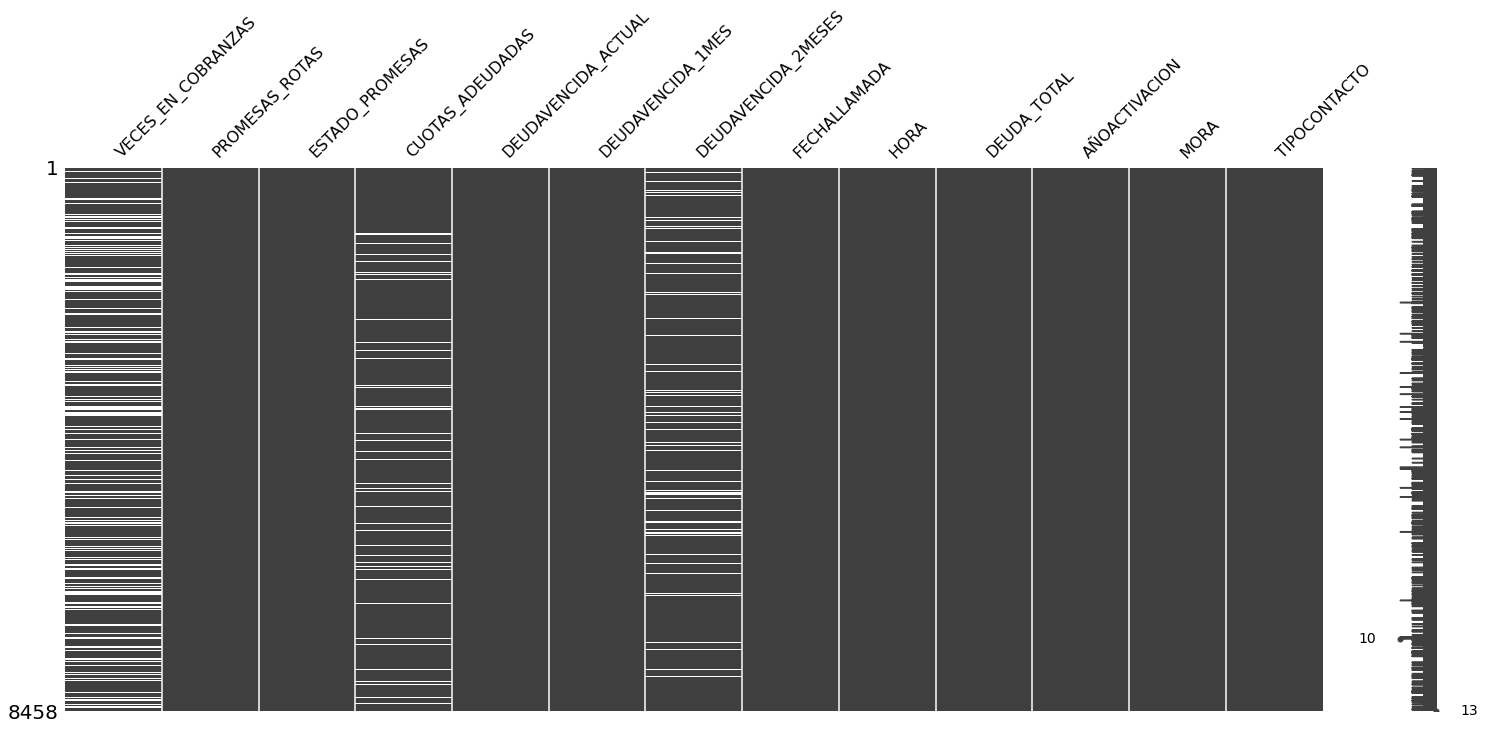

In [ ]:
#graficamente analizamos los nulos
import missingno as msno
msno.matrix(df)
#observamos que hay bastantes valores nulos en las 3 columnas, por lo que no eliminamos filas

**Tratamiento de nulos**

In [ ]:
df_cat = df.select_dtypes(include=["object","datetime"])
df_num = df.select_dtypes("number")

In [ ]:
#aplicamos imputacion simple de los mas frecuentes a las variables categoricas nulas
from sklearn.impute import SimpleImputer
imputer_cat = SimpleImputer(strategy="most_frequent")
imputer_cat.fit(df_cat)
df_cat_imputed = pd.DataFrame(imputer_cat.transform(df_cat), columns = df_cat.columns)
df_cat_imputed.isnull().sum()

VECES_EN_COBRANZAS    0
PROMESAS_ROTAS        0
CUOTAS_ADEUDADAS      0
FECHALLAMADA          0
TIPOCONTACTO          0
dtype: int64

In [ ]:
print('Ceros: {}'.format((df['DEUDAVENCIDA_2MESES']==0).sum()))
print('Diferente a Cero: {}'.format((df['DEUDAVENCIDA_2MESES']!=0).sum()))
print('Nulos: {}\n'.format(df['DEUDAVENCIDA_2MESES'].isnull().sum()))
#la mayoria de data tiene 0
#los nulos representan el 9.6%

Ceros: 4711
Diferente a Cero: 3747
Nulos: 901



In [ ]:
#no usamos medianas porque no tiene sentido asignarle una misma deuda a todos los nulos
#la mayoria de registros tiene el valor de cero
#por tanto aplicamos imputacion de algoritmo KNN a variables numericas nulas
from sklearn.impute import KNNImputer
knn = KNNImputer(n_neighbors=5)
df_num_knn = pd.DataFrame(data=knn.fit_transform(df_num),columns=df_num.columns)
df_num_knn.isnull().sum()

ESTADO_PROMESAS        0
DEUDAVENCIDA_ACTUAL    0
DEUDAVENCIDA_1MES      0
DEUDAVENCIDA_2MESES    0
HORA                   0
DEUDA_TOTAL            0
AÑOACTIVACION          0
MORA                   0
dtype: int64

In [ ]:
df2=pd.concat([df_num_knn,df_cat_imputed], axis=1)
df2.head()

,ESTADO_PROMESAS,DEUDAVENCIDA_ACTUAL,DEUDAVENCIDA_1MES,DEUDAVENCIDA_2MESES,HORA,DEUDA_TOTAL,AÑOACTIVACION,MORA,VECES_EN_COBRANZAS,PROMESAS_ROTAS,CUOTAS_ADEUDADAS,FECHALLAMADA,TIPOCONTACTO
0,0.0,244.86,0.00,245.26,15.0,3816.34,2012.0,1.0,<=10,0,"<24, 48]",2014-02-03,COEF
1,0.0,610.58,612.69,611.54,9.0,13620.50,2012.0,1.0,<=10,0,>48,2014-02-18,COEF
2,0.0,2138.73,0.00,0.00,16.0,18968.50,2013.0,0.0,<=10,>0,"<24, 48]",2014-02-05,CNE
3,0.0,323.07,46.85,74.26,19.0,2459.84,2012.0,0.0,>10,0,"<24, 48]",2014-02-24,CNE
4,0.0,920.54,0.00,0.00,14.0,6591.76,2013.0,0.0,<=10,0,"<24, 48]",2014-02-12,CNE


Tranformarmos las variables hora y fechallamada para un mejor analisis

In [ ]:
df2["PERIODO_DIA"]=pd.cut(df2["HORA"], bins=[6,12,18,24], labels=["mañana","tarde","noche"])
df2=df2.drop(["HORA"],axis=1)

In [ ]:
df2["DIA_SEMANA"]=df2["FECHALLAMADA"].dt.day_name()
df2=df2.drop(["FECHALLAMADA"],axis=1)

In [ ]:
#por la informacion asumimos que estamos en el 2015
df2["ANTIGUEDAD"]=2015-df2["AÑOACTIVACION"]
df2=df2.drop(["AÑOACTIVACION"],axis=1)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8458 entries, 0 to 8457
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ESTADO_PROMESAS      8458 non-null   float64 
 1   DEUDAVENCIDA_ACTUAL  8458 non-null   float64 
 2   DEUDAVENCIDA_1MES    8458 non-null   float64 
 3   DEUDAVENCIDA_2MESES  8458 non-null   float64 
 4   DEUDA_TOTAL          8458 non-null   float64 
 5   MORA                 8458 non-null   float64 
 6   VECES_EN_COBRANZAS   8458 non-null   object  
 7   PROMESAS_ROTAS       8458 non-null   object  
 8   CUOTAS_ADEUDADAS     8458 non-null   object  
 9   TIPOCONTACTO         8458 non-null   object  
 10  PERIODO_DIA          8458 non-null   category
 11  DIA_SEMANA           8458 non-null   object  
 12  ANTIGUEDAD           8458 non-null   float64 
dtypes: category(1), float64(7), object(5)
memory usage: 801.5+ KB


# **4. Analisis Univariado**

In [ ]:
#La variable objetivo TIPOCONTACTO esta como categoria
# contacto efectivo = 1
# contacto no efectivo = 0
df2["TIPOCONTACTO"] = df2["TIPOCONTACTO"].map({"CNE":0,"COEF":1})

Numero de clientes con Contacto No Efectivo: 5974
Numero de clientes con Contacto Efectivo: 2484



<AxesSubplot:xlabel='TIPOCONTACTO', ylabel='count'>

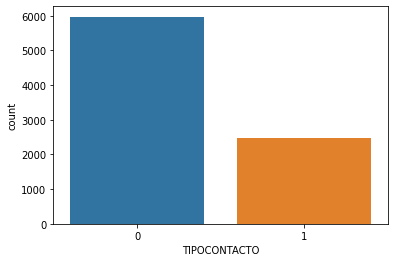

In [ ]:
print('Numero de clientes con Contacto No Efectivo: {}'.format((df2['TIPOCONTACTO'] == 0).sum()))
print('Numero de clientes con Contacto Efectivo: {}\n'.format((df2['TIPOCONTACTO'] == 1).sum()))


sns.countplot(x='TIPOCONTACTO', data=df2)
#observamos que la variable dependiente esta desbalanceada (menor contacto efectivo)

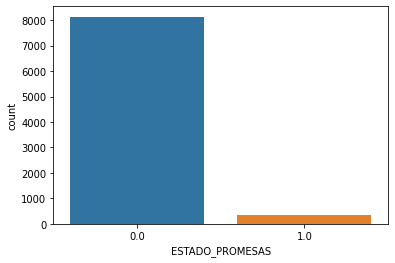

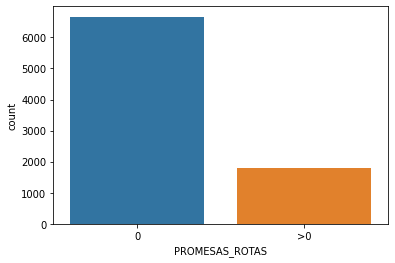

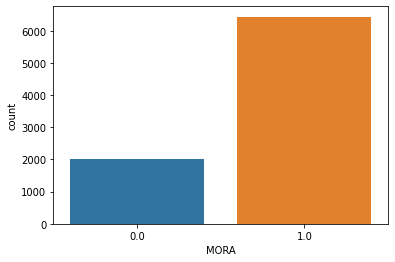

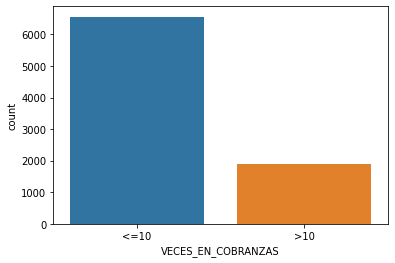

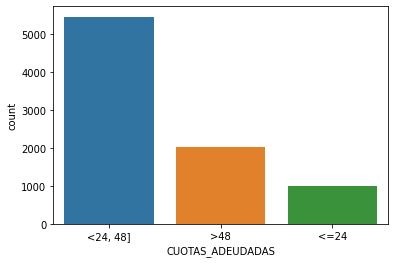

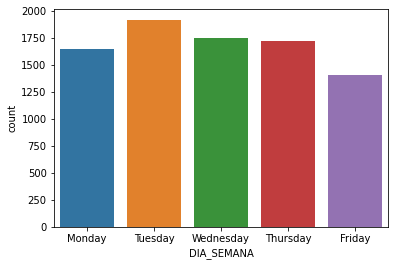

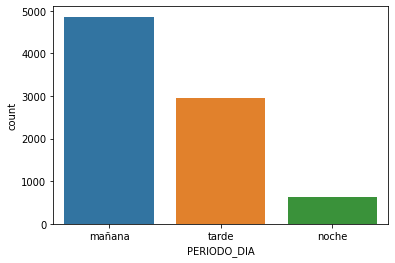

In [ ]:
cat_features=['ESTADO_PROMESAS','PROMESAS_ROTAS', 'MORA',
       'VECES_EN_COBRANZAS', 'CUOTAS_ADEUDADAS',"DIA_SEMANA",'PERIODO_DIA']
for feature in cat_features:
    sns.countplot(data = df2, x=feature)
    plt.show()

#existen pocas promesas de pago (1:con promesa, 0:sin promesa)
#hay un numero menor de promesas rotas
#hay mayor MORA=1 que indica que es clasificacion NORMAL (0 es deficiente)
#el dia martes es donde se hacen mayor llamadas
#en PERIODODIA se observa que hay mayor cantidad de llamadas en la mañana y poco en la noche


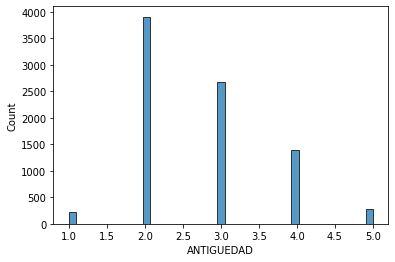

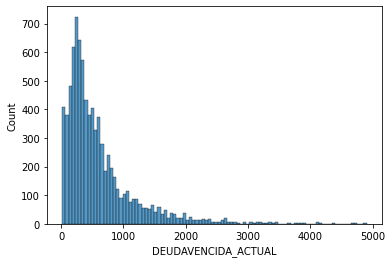

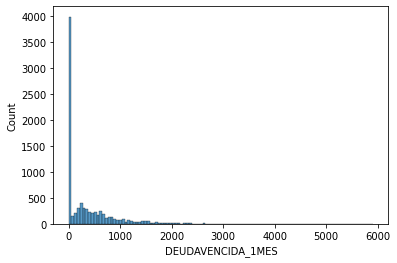

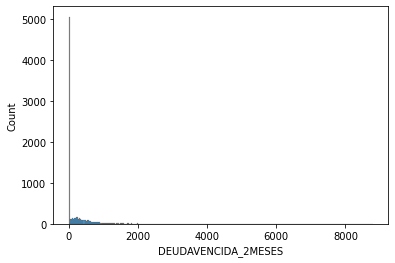

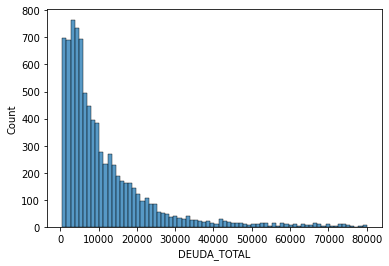

In [ ]:
num_features=['ANTIGUEDAD','DEUDAVENCIDA_ACTUAL','DEUDAVENCIDA_1MES', 'DEUDAVENCIDA_2MESES', 'DEUDA_TOTAL']
for feature in num_features:
    sns.histplot(data=df2, x=feature)
    plt.show()

#ANTIGUEDAD de 2 a 3 años tuvieron mas llamadas
#DEUDAVENCIDA_1MES y DEUDAVENCIDA_2MESES tienen mayor cantidad con cero deudavencida
#hay outliers

# **5. Analisis de Correlación**

<AxesSubplot:>

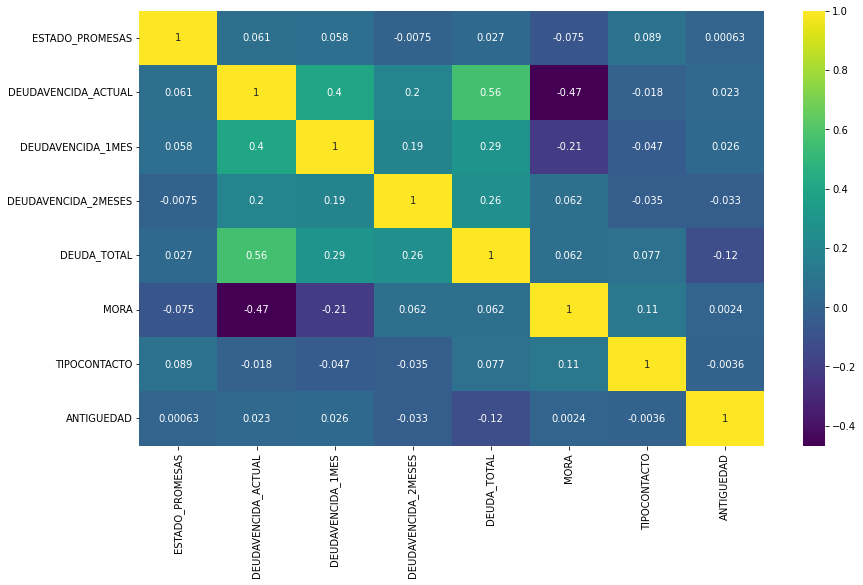

In [ ]:
plt.figure(figsize=(14,8))
sns.heatmap(df2.corr(), annot=True, cmap="viridis")
#se observa que no hay mucha correlacion entre las variables independiente con la variable dependiente TIPOCONTACTO
#estado_promesas y mora son variables categoricas (no debe analizarse)
#DEUDAVENCIDA_ACTUAL tiene una correlacion media con DEUDAVENCID_1MES, DEUDA_TOTAL y MORA

**variables numericas vs target**

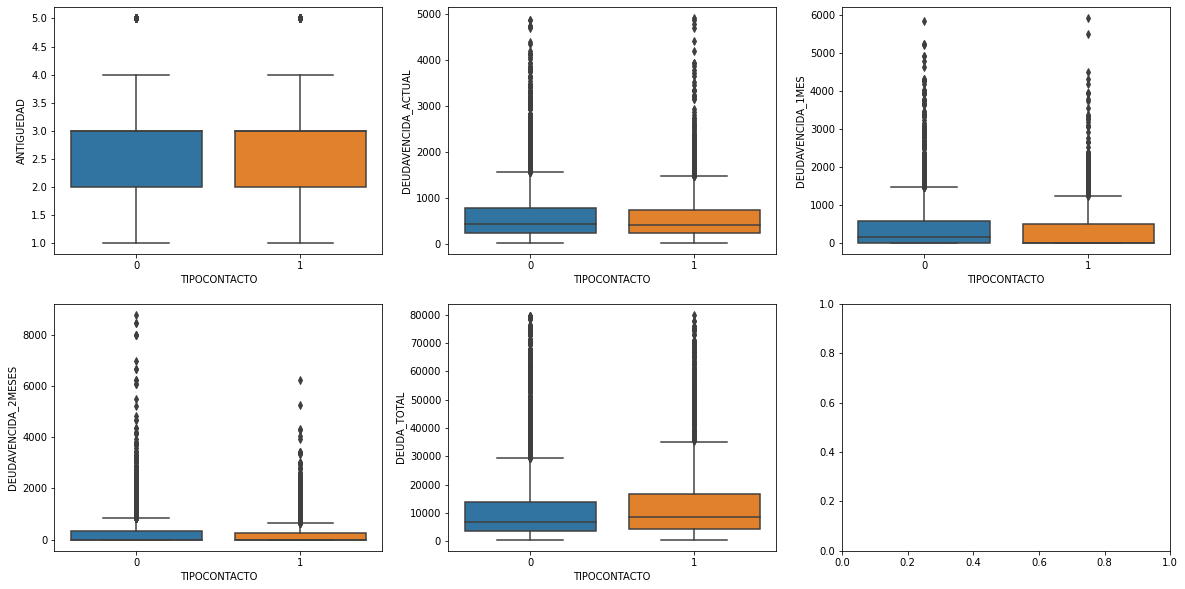

In [ ]:
_, axss = plt.subplots(2, 3, figsize=[20, 10])
for i in range(len(num_features)):
    sns.boxplot(x='TIPOCONTACTO', y=num_features[i], data=df2, ax=axss[i//3][i%3])

#se observan outliers y las variables son muy similares

**variables categoricas vs target**

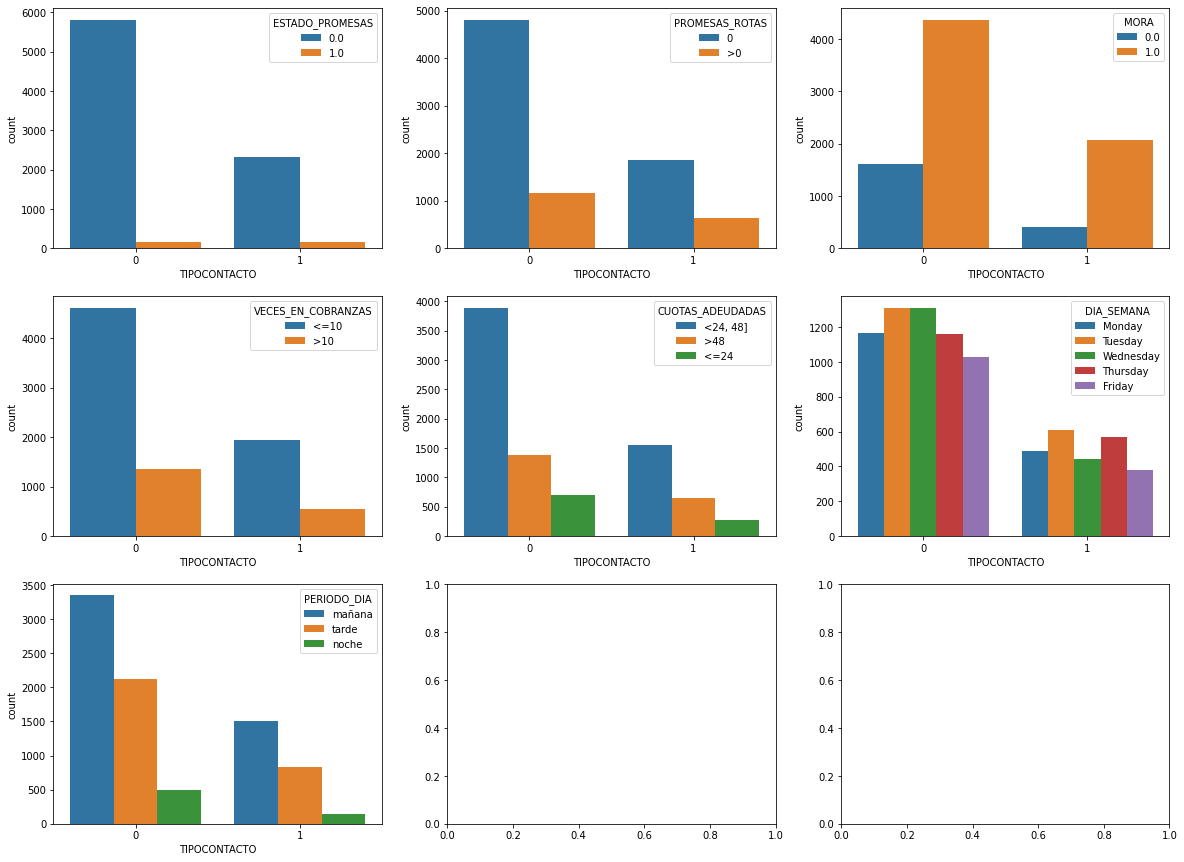

In [ ]:
_, axss = plt.subplots(3, 3, figsize=[20, 15])
for i in range(len(cat_features)):
    sns.countplot(x='TIPOCONTACTO', hue=cat_features[i], data=df2, ax=axss[i//3][i%3])

#clientes con mora normal(1) tienen mayor contacto efectivo (COEF=1)
#clientes con estado sin promesas (0), tiene mayor COEF
#los dias martes y jueves hay mayor COEF
#por la mañana hay mayor COEF

# **6. Tratamiento de Outliers**


In [ ]:
#outliers
num_cols=['DEUDAVENCIDA_ACTUAL','DEUDAVENCIDA_1MES', 'DEUDAVENCIDA_2MESES', 'DEUDA_TOTAL']
df2_num = pd.DataFrame(data=df2[num_cols])
df2_num[num_cols]=df2[num_cols].apply(lambda x: np.log(x+1))
df2=df2.drop(num_cols,axis=1)

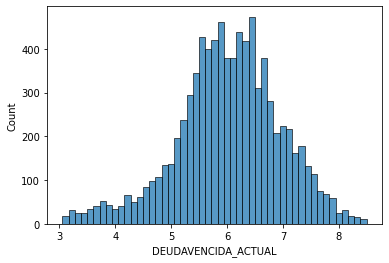

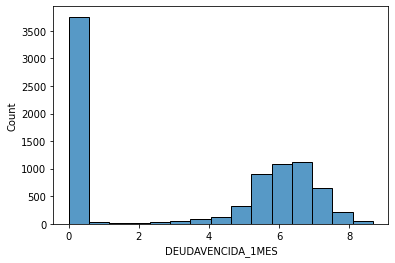

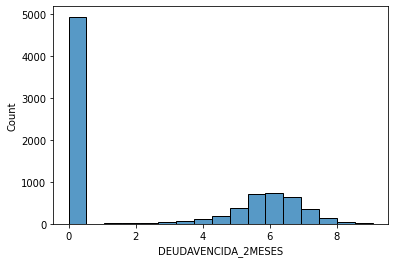

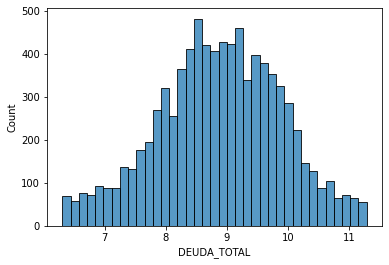

In [ ]:
for feature in num_cols:
    sns.histplot(data=df2_num, x=feature)
    plt.show()

# **7. Tratamiento de variables categoricas**

In [ ]:
#LABEL ENCODING
df2["PROMESAS_ROTAS"] = df2["PROMESAS_ROTAS"].map({"0":0,">0":1})
df2["VECES_EN_COBRANZAS"] = df2["VECES_EN_COBRANZAS"].map({"<=10":0,">10":1})
df2["CUOTAS_ADEUDADAS"] = df2["CUOTAS_ADEUDADAS"].map({"<=24":0,"<24, 48]":1,">48":2})

In [ ]:
#ONE HOT ENCODING
cat_cols=['CUOTAS_ADEUDADAS',"DIA_SEMANA",'PERIODO_DIA']
df2_cat = pd.get_dummies(data=df2[cat_cols], columns=cat_cols)
df2=df2.drop(cat_cols,axis=1)

In [ ]:
df2_cat.head()

,CUOTAS_ADEUDADAS_0,CUOTAS_ADEUDADAS_1,CUOTAS_ADEUDADAS_2,DIA_SEMANA_Friday,DIA_SEMANA_Monday,DIA_SEMANA_Thursday,DIA_SEMANA_Tuesday,DIA_SEMANA_Wednesday,PERIODO_DIA_mañana,PERIODO_DIA_tarde,PERIODO_DIA_noche
0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,0,0,1,0,1,0,0
2,0,1,0,0,0,0,0,1,0,1,0
3,0,1,0,0,1,0,0,0,0,0,1
4,0,1,0,0,0,0,0,1,0,1,0


In [ ]:
df3 = pd.concat([df2,df2_num,df2_cat], axis=1)
df3 = df3.astype({"ESTADO_PROMESAS":"int64","MORA":"int64","ANTIGUEDAD":"int64"})
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8458 entries, 0 to 8457
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ESTADO_PROMESAS       8458 non-null   int64  
 1   MORA                  8458 non-null   int64  
 2   VECES_EN_COBRANZAS    8458 non-null   int64  
 3   PROMESAS_ROTAS        8458 non-null   int64  
 4   TIPOCONTACTO          8458 non-null   int64  
 5   ANTIGUEDAD            8458 non-null   int64  
 6   DEUDAVENCIDA_ACTUAL   8458 non-null   float64
 7   DEUDAVENCIDA_1MES     8458 non-null   float64
 8   DEUDAVENCIDA_2MESES   8458 non-null   float64
 9   DEUDA_TOTAL           8458 non-null   float64
 10  CUOTAS_ADEUDADAS_0    8458 non-null   uint8  
 11  CUOTAS_ADEUDADAS_1    8458 non-null   uint8  
 12  CUOTAS_ADEUDADAS_2    8458 non-null   uint8  
 13  DIA_SEMANA_Friday     8458 non-null   uint8  
 14  DIA_SEMANA_Monday     8458 non-null   uint8  
 15  DIA_SEMANA_Thursday  

# **Escalamiento**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

escalar_cols=['ANTIGUEDAD','DEUDAVENCIDA_ACTUAL','DEUDAVENCIDA_1MES', 'DEUDAVENCIDA_2MESES', 'DEUDA_TOTAL']
scaler=MinMaxScaler()
df3_escalar=pd.DataFrame(data=scaler.fit_transform(df3[escalar_cols]), columns=escalar_cols)

df3=df3.drop(escalar_cols,axis=1)

df3=pd.concat([df3,df3_escalar], axis=1)
df3.head()

,ESTADO_PROMESAS,MORA,VECES_EN_COBRANZAS,PROMESAS_ROTAS,TIPOCONTACTO,CUOTAS_ADEUDADAS_0,CUOTAS_ADEUDADAS_1,CUOTAS_ADEUDADAS_2,DIA_SEMANA_Friday,DIA_SEMANA_Monday,...,DIA_SEMANA_Tuesday,DIA_SEMANA_Wednesday,PERIODO_DIA_mañana,PERIODO_DIA_tarde,PERIODO_DIA_noche,ANTIGUEDAD,DEUDAVENCIDA_ACTUAL,DEUDAVENCIDA_1MES,DEUDAVENCIDA_2MESES,DEUDA_TOTAL
0,0,1,0,0,1,0,1,0,0,1,...,0,0,0,1,0,0.50,0.450381,0.000000,0.606317,0.389710
1,0,1,0,0,1,0,0,1,0,0,...,1,0,1,0,0,0.50,0.617688,0.739195,0.706653,0.644895
2,0,0,0,1,0,0,1,0,0,0,...,0,1,0,1,0,0.25,0.847620,0.000000,0.000000,0.711332
3,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0.50,0.501089,0.445403,0.475786,0.301635
4,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0.25,0.692962,0.000000,0.000000,0.499323


<AxesSubplot:>

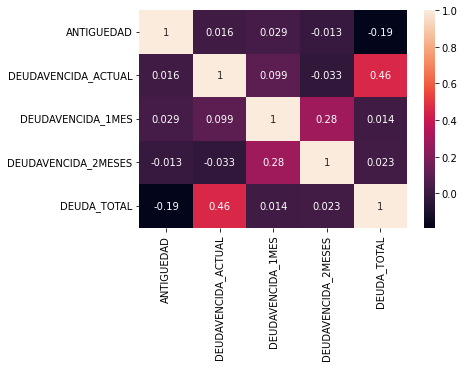

In [ ]:
sns.heatmap(df3_escalar.corr(), annot=True)
#la deudavencida_actual y deudatotal tiene una correlacion media, las demas variables es bajo, por tanto no hay multicolinealidad

# **8. Modelo Predictivo - Cross Validation y Entrenamiento**

In [ ]:
X = df3.drop("TIPOCONTACTO", axis=1)
y = df3["TIPOCONTACTO"]

In [ ]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=15)

print('Data Entrenamiento: {} x {}'.format(X_train.shape[0], X_train.shape[1]))
print('Data de prueba:     {} x {}'.format(X_test.shape[0], X_test.shape[1]))

Data Entrenamiento: 6766 x 20
Data de prueba:     1692 x 20


**Modelo con valores default**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

model_lr = LogisticRegression()
model_knn = KNeighborsClassifier()
model_rf = RandomForestClassifier()
model_xgb = XGBClassifier()
model_dt = DecisionTreeClassifier()
model_ada = AdaBoostClassifier()

In [ ]:
#CROSS VALIDATION
models = [model_lr, model_knn, model_rf, model_xgb, model_dt, model_ada]
accuracies = []
for model in models:
    cv_scores = model_selection.cross_val_score(model, X_train, y_train, cv=10)
    accuracies.append(cv_scores.mean())

In [ ]:
print('''
Model CROSS Validation Accuracy (PROMEDIO)
Logistic Regression: {}
K Nearest Neighbors: {}
Random Forest:       {}
XGBoost:             {}
Decision Tree:       {}
AdaBoost:            {}
'''.format(*accuracies))

#se observa mayor accuracy en Logistic, AdaBoost y random Forest


Model CROSS Validation Accuracy (PROMEDIO)
Logistic Regression: 0.704404656813474
K Nearest Neighbors: 0.6579907877601322
Random Forest:       0.6899159186456084
XGBoost:             0.686522073540594
Decision Tree:       0.6328684240427225
AdaBoost:            0.7029260223925602



**Modelos con Hiperparametros**

In [ ]:
from sklearn.model_selection import GridSearchCV

def validate_and_test(model, params, model_name):
    print('Model: {}\n'.format(model_name))

    #entrenamiento de los modelos
    gscv = GridSearchCV(model, params, cv=10)
    gscv.fit(X_train, y_train)
    print('Best parameter set: {}\nTrain accuracy: {}'\
        .format(gscv.best_params_, gscv.best_score_))

    # Model Testing tambien se valida para ver el overfit en la data test vs train
    best_model = gscv.best_estimator_
    test_accuracy = best_model.score(X_test, y_test)
    print('Test accuracy: {}'.format(test_accuracy))

    return best_model

In [ ]:
#REGRESION LOGISTICA
model_lr = LogisticRegression(solver='liblinear')
params_lr = {
    'penalty': ('l1', 'l2'),
    'C': (0.01, 0.05, 0.1, 0.2, 0.5, 1)
}
best_model_lr = validate_and_test(model_lr, params_lr, 'Logistic Regression')

#se observa que el accuracy de la data Train y Test es similar

Model: Logistic Regression

Best parameter set: {'C': 0.05, 'penalty': 'l1'}
Train accuracy: 0.7091331404648072
Test accuracy: 0.7033096926713948


In [ ]:
# MODELO KNN
model_knn = KNeighborsClassifier()
params_knn = {
    'n_neighbors': range(1, 30, 4),
    'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
}
best_model_knn = validate_and_test(model_knn, params_knn, 'K Nearest Neighbors')

Model: K Nearest Neighbors

Best parameter set: {'algorithm': 'auto', 'n_neighbors': 21}
Train accuracy: 0.7048480067824461
Test accuracy: 0.7027186761229315


In [ ]:
#RANDOM FOREST
model_rf = RandomForestClassifier()
params_rf = {
    'n_estimators': range(40, 100, 20),
    'max_depth': range(1, 20, 2),
}
best_model_rf = validate_and_test(model_rf, params_rf, 'Random Forest')

Model: Random Forest

Best parameter set: {'max_depth': 5, 'n_estimators': 40}
Train accuracy: 0.7067695541590553
Test accuracy: 0.7039007092198581


In [ ]:
#MODELO XGBOOST
model_xgb = XGBClassifier()
params_xgb = {
    'booster': ['gbtree', 'gblinear'],
	'eta': [0.1, 0.5, 1],
    'max_depth': range(3, 11, 3),
	'n_estimators': range(20, 61, 20),
	'subsample': [0.25, 0.5, 1]
}
best_model_xgb = validate_and_test(model_xgb, params_xgb, 'XGBoost')

Model: XGBoost

[17:42:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[17:42:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[17:42:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[17:42:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[17:42:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[17:42:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[17:42:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[17:42:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[17:42:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[17:42:25] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" }

In [ ]:
#DECISION TREE
model_dt = DecisionTreeClassifier()
params_dt = {'criterion': ['gini', 'entropy'],
              'max_depth': [3, 5, 7, 9],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2']}
best_model_dt = validate_and_test(model_dt, params_dt, 'Decision Tree')

Model: Decision Tree

Best parameter set: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5}
Train accuracy: 0.7088392490363857
Test accuracy: 0.7056737588652482


In [ ]:
#ADA BOOST
model_ada = AdaBoostClassifier()
param_ada = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.1, 0.5, 1.0, 2.0]}
best_model_ada = validate_and_test(model_ada, param_ada, 'AdaBoost')

Model: AdaBoost

Best parameter set: {'learning_rate': 0.1, 'n_estimators': 100}
Train accuracy: 0.7094276874131437
Test accuracy: 0.7021276595744681


# **9. Evaluacion Modelo con data Test**

In [ ]:
model_names = ['Logistic Regression', 'K Nearest Neighbor', 'Random Forest', 'XGBoost','Decision Tree','AdaBoost']
best_models = [best_model_lr, best_model_knn, best_model_rf, best_model_xgb, best_model_dt, best_model_ada]
test_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

test_results = {
    'Logistic Regression': [],
    'K Nearest Neighbor': [],
    'Random Forest': [],
    'XGBoost': [],
    'Decision Tree': [],
    'AdaBoost': [],
}

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(model, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    test_results[model_name].extend([accuracy, precision, recall, f1])
    print('Model:     {}'.format(model_name))
    print('Accuracy:  {}'.format(accuracy))
    print('Precision: {}'.format(precision))
    print('Recall:    {}'.format(recall))
    print('F1-Score:  {}'.format(f1))
    print()

In [ ]:
for i in range(len(model_names)):
    evaluate(best_models[i], model_names[i])

Model:     Logistic Regression
Accuracy:  0.7033096926713948
Precision: 0.3684210526315789
Recall:    0.014084507042253521
F1-Score:  0.027131782945736437

Model:     K Nearest Neighbor
Accuracy:  0.7027186761229315
Precision: 0.4722222222222222
Recall:    0.10261569416498995
F1-Score:  0.16859504132231407

Model:     Random Forest
Accuracy:  0.7039007092198581
Precision: 0.16666666666666666
Recall:    0.002012072434607646
F1-Score:  0.003976143141153081

Model:     XGBoost
Accuracy:  0.706855791962175
Precision: 0.5161290322580645
Recall:    0.03219315895372234
F1-Score:  0.06060606060606061

Model:     Decision Tree
Accuracy:  0.7056737588652482
Precision: 0.4
Recall:    0.004024144869215292
F1-Score:  0.00796812749003984

Model:     AdaBoost
Accuracy:  0.7021276595744681
Precision: 0.3333333333333333
Recall:    0.014084507042253521
F1-Score:  0.027027027027027032



**ROC y AUC**

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
def draw_CM_roc_curve(model, model_name):
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    # Calculate AUC
    auc = metrics.auc(fpr, tpr)
    test_results[model_name].append(auc)
    print('{}\nAUC = {}\n'.format(model_name, auc))

    #se agrego matriz de confusion
    predictions = model.predict(X_test)
    conf_mtx = confusion_matrix(y_test, predictions)

    f, axes = plt.subplots(ncols=2, figsize=(15,5))
    sns.heatmap(conf_mtx, annot=True, cbar=False, ax=axes[0], fmt="g",cmap="Blues",annot_kws={"size":14})
    axes[0].set_xlabel("Predicted Labels")
    axes[0].set_ylabel("Real Labels")
    axes[0].set_title("Confusion Matrix");
    axes[0].xaxis.set_ticklabels(["CNE", "COEF"]);
    axes[0].yaxis.set_ticklabels(["CNE", "COEF"]);


    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].plot(fpr, tpr, label='ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_name)
    plt.legend(loc='best')

    plt.show()

Logistic Regression
AUC = 0.6162077064899859



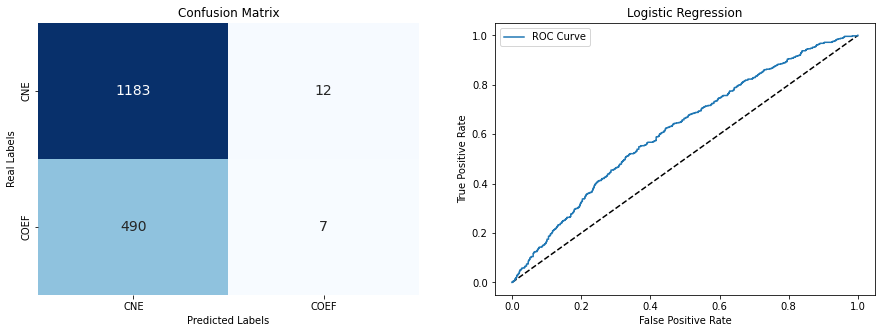

K Nearest Neighbor
AUC = 0.5864374531709083



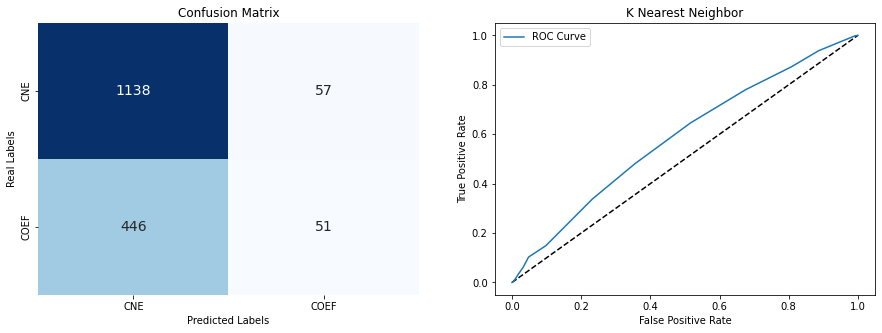

Random Forest
AUC = 0.6359344350622564



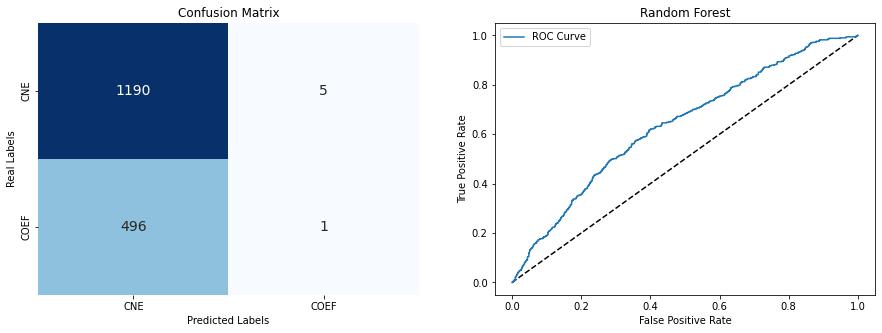

XGBoost
AUC = 0.6013326822861857



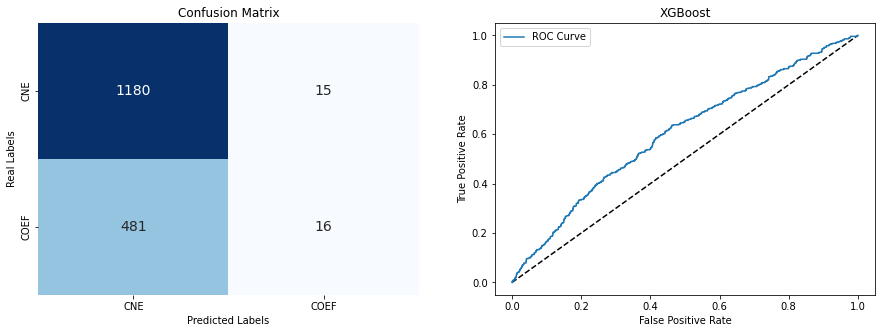

Decision Tree
AUC = 0.565113694720625



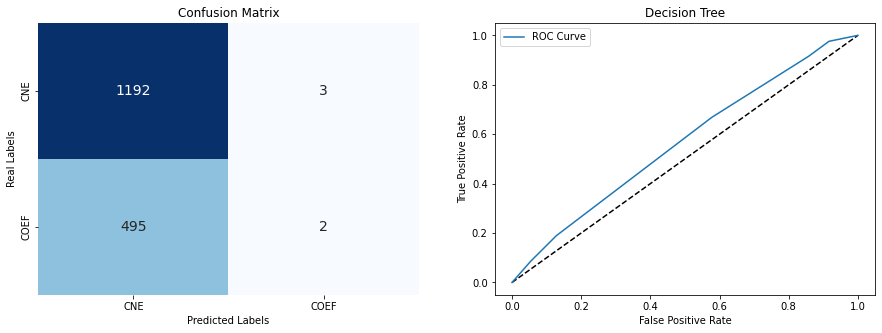

AdaBoost
AUC = 0.6275662342254362



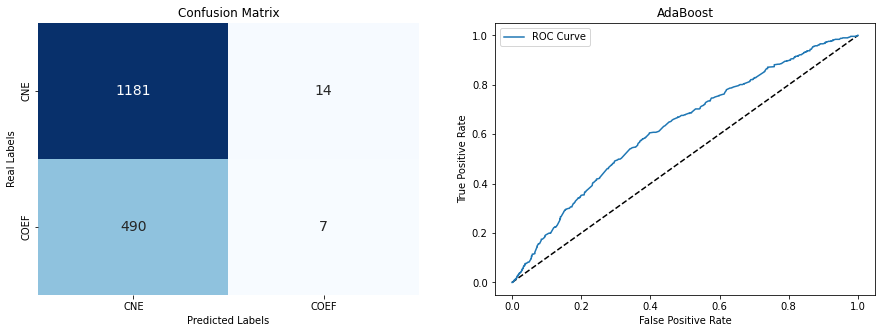

In [ ]:
for best_model, model_name in zip(best_models, model_names):
    draw_CM_roc_curve(best_model, model_name)

#el mejor AUC es del Random Forest = 0.6359344350622564

# **Balanceo de la variable objetivo**

In [ ]:
from sklearn.utils import resample

majority = df3[df3["TIPOCONTACTO"]==0] #CNE
minority = df3[df3["TIPOCONTACTO"]==1] #COEF

majority.shape, minority.shape

((5974, 21), (2484, 21))

Numero de clientes con Concacto No Efectivo: 5974
Numero de clientes con Concacto Efectivo: 5974



<AxesSubplot:xlabel='TIPOCONTACTO', ylabel='count'>

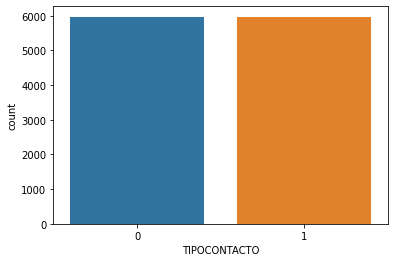

In [ ]:
minority_upsampled = resample(minority, replace=True, n_samples=5974, random_state=15)
df4 = pd.concat([majority, minority_upsampled])

print('Numero de clientes con Concacto No Efectivo: {}'.format((df4['TIPOCONTACTO'] == 0).sum()))
print('Numero de clientes con Concacto Efectivo: {}\n'.format((df4['TIPOCONTACTO'] == 1).sum()))

sns.countplot(x='TIPOCONTACTO', data=df4)

In [ ]:
X = df4.drop("TIPOCONTACTO", axis=1)
y= df4["TIPOCONTACTO"]
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=15)


In [ ]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11948 entries, 2 to 7932
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ESTADO_PROMESAS       11948 non-null  int64  
 1   MORA                  11948 non-null  int64  
 2   VECES_EN_COBRANZAS    11948 non-null  int64  
 3   PROMESAS_ROTAS        11948 non-null  int64  
 4   TIPOCONTACTO          11948 non-null  int64  
 5   CUOTAS_ADEUDADAS_0    11948 non-null  uint8  
 6   CUOTAS_ADEUDADAS_1    11948 non-null  uint8  
 7   CUOTAS_ADEUDADAS_2    11948 non-null  uint8  
 8   DIA_SEMANA_Friday     11948 non-null  uint8  
 9   DIA_SEMANA_Monday     11948 non-null  uint8  
 10  DIA_SEMANA_Thursday   11948 non-null  uint8  
 11  DIA_SEMANA_Tuesday    11948 non-null  uint8  
 12  DIA_SEMANA_Wednesday  11948 non-null  uint8  
 13  PERIODO_DIA_mañana    11948 non-null  uint8  
 14  PERIODO_DIA_tarde     11948 non-null  uint8  
 15  PERIODO_DIA_noche   

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11948 entries, 2 to 7932
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ESTADO_PROMESAS       11948 non-null  int64  
 1   MORA                  11948 non-null  int64  
 2   VECES_EN_COBRANZAS    11948 non-null  int64  
 3   PROMESAS_ROTAS        11948 non-null  int64  
 4   CUOTAS_ADEUDADAS_0    11948 non-null  uint8  
 5   CUOTAS_ADEUDADAS_1    11948 non-null  uint8  
 6   CUOTAS_ADEUDADAS_2    11948 non-null  uint8  
 7   DIA_SEMANA_Friday     11948 non-null  uint8  
 8   DIA_SEMANA_Monday     11948 non-null  uint8  
 9   DIA_SEMANA_Thursday   11948 non-null  uint8  
 10  DIA_SEMANA_Tuesday    11948 non-null  uint8  
 11  DIA_SEMANA_Wednesday  11948 non-null  uint8  
 12  PERIODO_DIA_mañana    11948 non-null  uint8  
 13  PERIODO_DIA_tarde     11948 non-null  uint8  
 14  PERIODO_DIA_noche     11948 non-null  uint8  
 15  ANTIGUEDAD          

In [ ]:
df4.info()

In [ ]:
#REGRESION LOGISTICA
model_lr4 = LogisticRegression(solver='liblinear')
params_lr4 = {
    'penalty': ('l1', 'l2'),
    'C': (0.01, 0.05, 0.1, 0.2, 0.5, 1)
}
best_model_lr4 = validate_and_test(model_lr4, params_lr4, 'Logistic Regression')

Model: Logistic Regression

Best parameter set: {'C': 0.2, 'penalty': 'l1'}
Train accuracy: 0.6025323665359592
Test accuracy: 0.602928870292887


In [ ]:
# MODELO KNN
model_knn4 = KNeighborsClassifier()
params_knn4 = {
    'n_neighbors': range(1, 30, 4),
    'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
}
best_model_knn4 = validate_and_test(model_knn4, params_knn4, 'K Nearest Neighbors')

Model: K Nearest Neighbors

Best parameter set: {'algorithm': 'auto', 'n_neighbors': 1}
Train accuracy: 0.7933646958312341
Test accuracy: 0.8108786610878661


In [ ]:
#RANDOM FOREST
model_rf4 = RandomForestClassifier()
params_rf4 = {
    'n_estimators': range(40, 100, 20),
    'max_depth': range(1, 20, 2),
}
best_model_rf4 = validate_and_test(model_rf4, params_rf4, 'Random Forest')

Model: Random Forest

Best parameter set: {'max_depth': 19, 'n_estimators': 80}
Train accuracy: 0.8344821354246532
Test accuracy: 0.8422594142259414


In [ ]:
#MODELO XGBOOST
model_xgb4 = XGBClassifier()
params_xgb4 = {
    'booster': ['gbtree', 'gblinear'],
	'eta': [0.1, 0.5, 1],
    'max_depth': range(3, 11, 3),
	'n_estimators': range(20, 61, 20),
	'subsample': [0.25, 0.5, 1]
}
best_model_xgb4 = validate_and_test(model_xgb4, params_xgb4, 'XGBoost')

Model: XGBoost

[17:57:50] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[17:57:50] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[17:57:50] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[17:57:50] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[17:57:50] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[17:57:51] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[17:57:51] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[17:57:51] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[17:57:51] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[17:57:51] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "subsample" }

In [ ]:
#DECISION TREE
model_dt4 = DecisionTreeClassifier()
params_dt4 = {'criterion': ['gini', 'entropy'],
              'max_depth': [3, 5, 7, 9],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2']}
best_model_dt4 = validate_and_test(model_dt4, params_dt4, 'Decision Tree')

Model: Decision Tree

Best parameter set: {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
Train accuracy: 0.6164451576157199
Test accuracy: 0.6184100418410042


In [ ]:
#ADA BOOST
model_ada4 = AdaBoostClassifier()
param_ada4 = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.1, 0.5, 1.0, 2.0]}
best_model_ada4 = validate_and_test(model_ada4, param_ada4, 'AdaBoost')

Model: AdaBoost

Best parameter set: {'learning_rate': 1.0, 'n_estimators': 200}
Train accuracy: 0.6096451181844071
Test accuracy: 0.6184100418410042


In [ ]:
model_names = ['Logistic Regression', 'K Nearest Neighbor', 'Random Forest', 'XGBoost','Decision Tree','AdaBoost']
best_models = [best_model_lr4, best_model_knn4, best_model_rf4, best_model_xgb4, best_model_dt4, best_model_ada4]
test_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

test_results = {
    'Logistic Regression': [],
    'K Nearest Neighbor': [],
    'Random Forest': [],
    'XGBoost': [],
    'Decision Tree': [],
    'AdaBoost': [],
}

#EVALUACION
for i in range(len(model_names)):
    evaluate(best_models[i], model_names[i])

#random forest tiene mejores indicadores

Model:     Logistic Regression
Accuracy:  0.602928870292887
Precision: 0.6014851485148515
Recall:    0.6100418410041841
F1-Score:  0.6057332779393435

Model:     K Nearest Neighbor
Accuracy:  0.8108786610878661
Precision: 0.7674586033117351
Recall:    0.8920502092050209
F1-Score:  0.8250773993808049

Model:     Random Forest
Accuracy:  0.8422594142259414
Precision: 0.81656346749226
Recall:    0.8828451882845189
F1-Score:  0.848411741053478

Model:     XGBoost
Accuracy:  0.8263598326359832
Precision: 0.7880354505169868
Recall:    0.8928870292887029
F1-Score:  0.8371910553158102

Model:     Decision Tree
Accuracy:  0.6184100418410042
Precision: 0.6104605776736924
Recall:    0.6543933054393305
F1-Score:  0.6316639741518578

Model:     AdaBoost
Accuracy:  0.6184100418410042
Precision: 0.6151342554922702
Recall:    0.6326359832635984
F1-Score:  0.6237623762376239



Logistic Regression
AUC = 0.6390059697834422



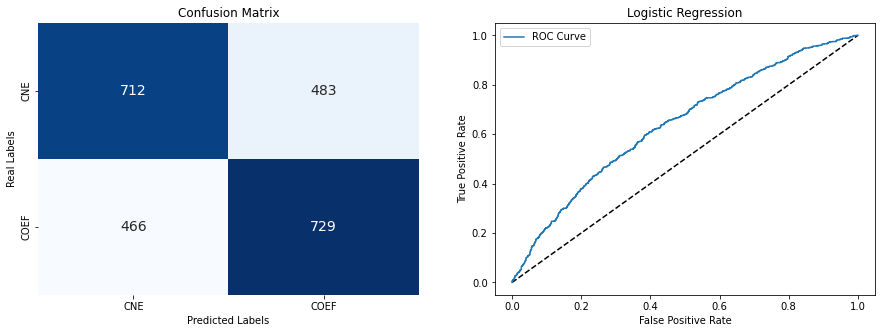

K Nearest Neighbor
AUC = 0.8108786610878661



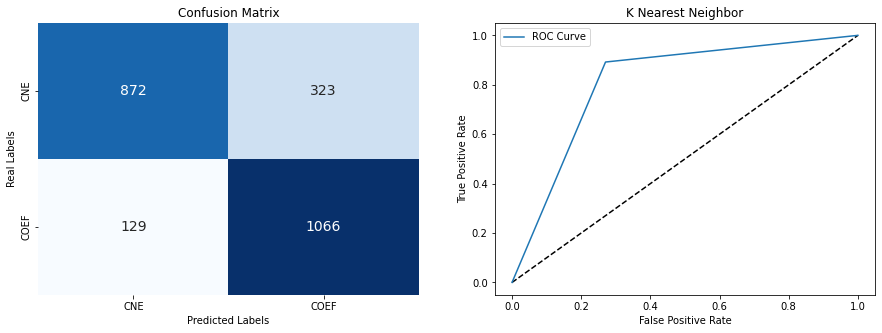

Random Forest
AUC = 0.9195864918331261



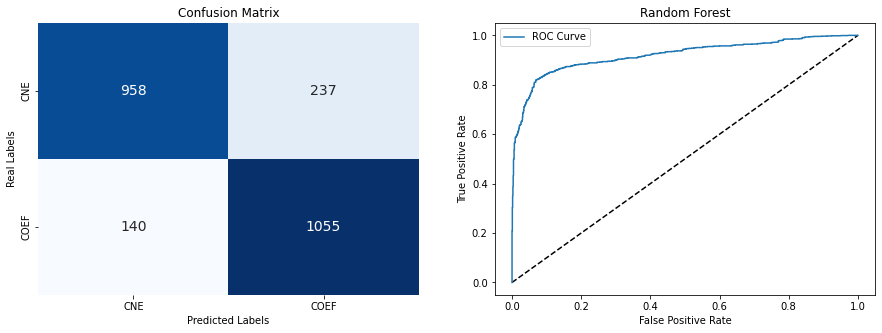

XGBoost
AUC = 0.889820906496735



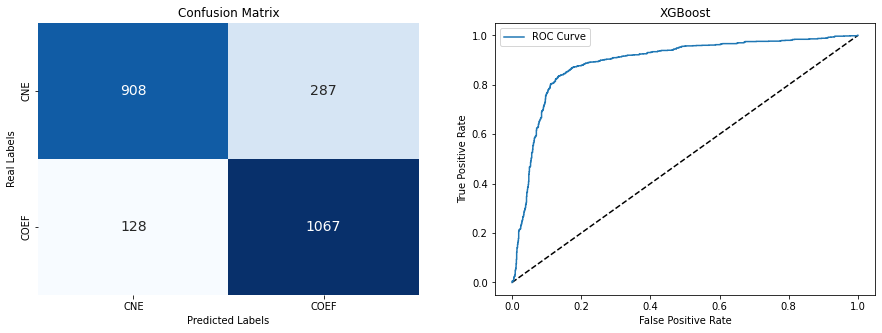

Decision Tree
AUC = 0.6634169569860471



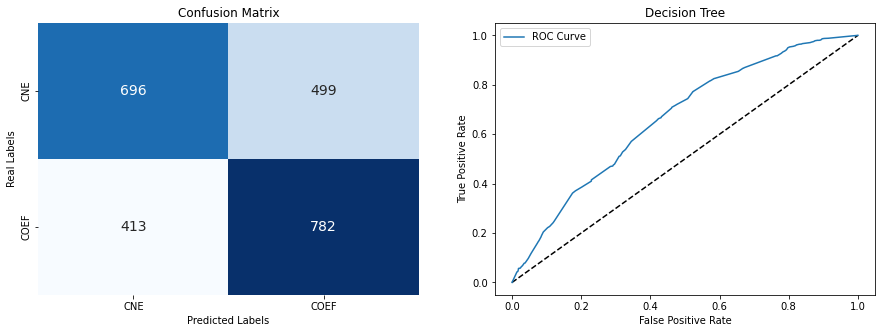

AdaBoost
AUC = 0.6679970588750197



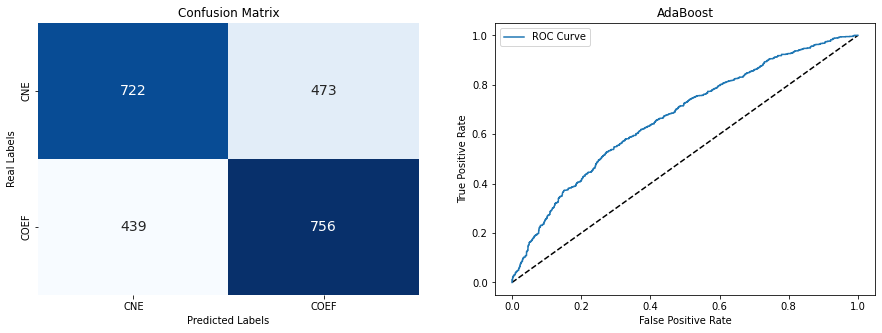

In [ ]:
#MATRIZ ROC AUC
for best_model, model_name in zip(best_models, model_names):
    draw_CM_roc_curve(best_model, model_name)

#el AUC de random Forest es mayor que los demas indicadores

# **SHAP VALUES**

In [ ]:
!pip install shap
import shap
explainer = shap.Explainer(best_model_rf4.predict, X_test) #random forest 4
shap_values = explainer(X_test)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 8.9 MB/s eta 0:00:00


Permutation explainer: 2391it [23:05,  1.72it/s]


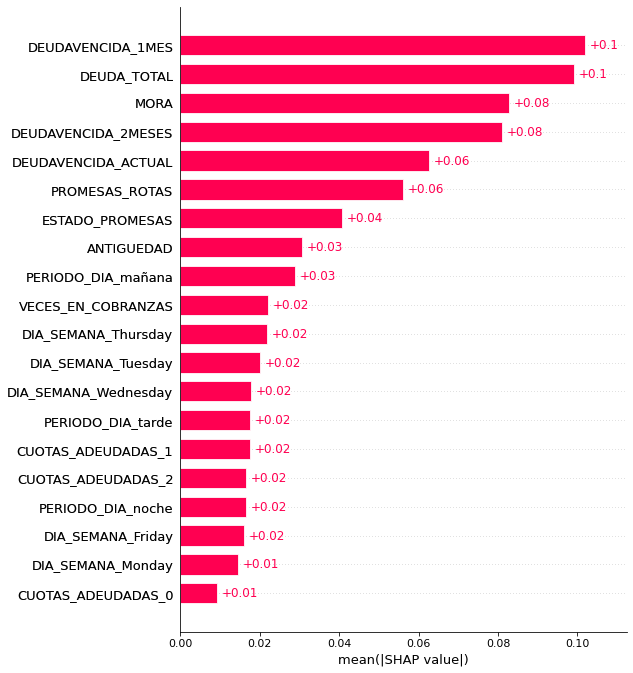

In [ ]:
shap.plots.bar(shap_values, max_display=20)
#estas son las variables independientes que son significativas para el contacto efectivo


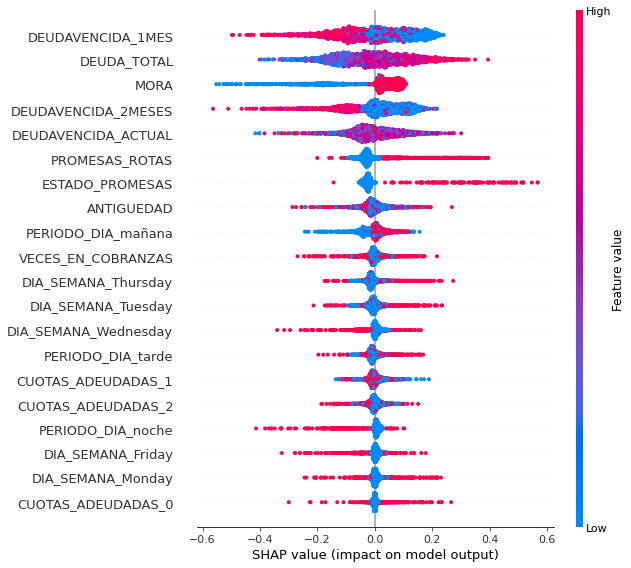

In [ ]:
shap.plots.beeswarm(shap_values, max_display=20)

# **Conclusiones**

Para tener mayor contactabilidad el negocio debe enfocarse en clientes con deuda vencida, deuda total, la mora, con promesas, antiguedad.

Si desea puede enfocarse en las demas como el periodo del dia (mañana) o el dia de la semana (Martes y Jueves)